# AB Testing Case study

In this analysis, I aim to evaluate the impact of altering the call-to-action button on our website. This test compares the click-through rates (CTR) for two different texts: 'Get your estimate' and 'Trade in now.' By running this test, we hope to determine if the new phrasing significantly increases user engagement.

I am conducting an A/B test to evaluate the impact. Our business hypothesis is that this modification will result in at least a 10% increase in CTR.

![Image](controlexperiment.png)

Null Hypothesis (H₀): There is no statistically significant difference in CTR between the control group and the experimental group.

Alternative Hypothesis (H₁): There is a statistically significant difference in CTR between the control group and the experimental group.

$$
\left\{
\begin{array}{ll}
H_0: P_{\text{con}} = P_{\text{exp}} \\
H_1: P_{\text{con}} \neq P_{\text{exp}}
\end{array}
\right.
$$


## Library Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

## Loading our Data
We load our dataset to analyze user behavior on the landing page, which includes 20,000 observations with four columns: user_id, click (1 for clicked, 0 for not clicked), group (control or experimental), and timestamp.

*(For the purposes of this case study demo, this data has been randomly generated.)*

In [15]:
# Load the data from the csv file
df_ab_test = pd.read_csv("ab_test_click_data.csv")
df_ab_test.head()

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00


In [16]:
df_ab_test.describe() #Descriptive statistics

,user_id,click
count,20000.000000,20000.000000
mean,10000.500000,0.405250
std,5773.647028,0.490953
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,0.000000
75%,15000.250000,1.000000
max,20000.000000,1.000000


We categorize the data by group (control vs. experimental) to observe the differences in click behavior.

In [3]:
df_ab_test.groupby("group").sum("click")

,user_id,click
group,,
con,150005000,1989
exp,50005000,6116


We create a bar chart to visually compare the click distribution between the two groups.

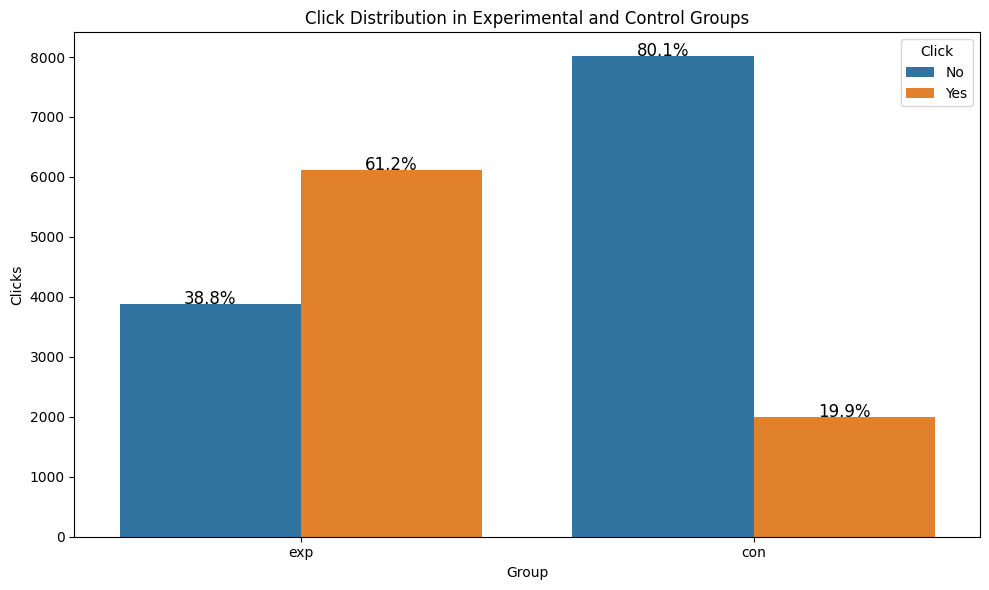

In [4]:

#Plotting
plt.figure(figsize=(10,6))
ax = sns.countplot(x='group', hue='click', data=df_ab_test)
plt.title('Click Distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.ylabel('Clicks')
plt.legend(title='Click', labels=['No', 'Yes'])

# Percentage Calculation for bar annotation
group_counts = df_ab_test.groupby(['group']).size()
group_click_counts = df_ab_test.groupby(['group', 'click']).size().reset_index(name='count')

for p in ax.patches:
    height = p.get_height()
    # Find group and click type for current bar
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    if height > 0 and total > 0:
        percentage = 100 * height / total
        ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}%', ha="center", color="black", fontsize=12)

plt.tight_layout()
plt.show()

This visualization reveals that 61.2% of users in the experimental group clicked the call-to-action button, while only 19.9% did so in the control group.

## Statistical Analysis Setup
We set up the parameters for our hypothesis test:

- $\alpha = 0.05$ (significance level)
- $\delta = 0.1$ (minimum detectable effect / practical significance)

In [5]:
alpha = 0.05
delta = 0.1

## Calculating clicks and users

In [6]:
N_con = df_ab_test[df_ab_test["group"] == "con"]["user_id"].count()
N_exp = df_ab_test[df_ab_test["group"] == "exp"]["user_id"].count()

X_con = df_ab_test.groupby("group")["click"].sum().loc["con"]
X_exp = df_ab_test.groupby("group")["click"].sum().loc["exp"]

print("Number of Users in Control: ",N_con)
print("Number of Users Experimental: ",N_exp)

print("Clicks in Control: ",X_con)
print("Clicks in Experimental: ",X_exp)

Number of Users in Control:  10000
Number of Users Experimental:  10000
Clicks in Control:  1989
Clicks in Experimental:  6116


## Estimating Clickthrough Rates
We calculate the clickthrough rates for both groups.

$\hat{p}_{\text{con}} = \frac{X_{\text{con}}}{N_{\text{con}}} = \frac{\# \text{clicks}_{\text{con}}}{\# \text{impressions}_{\text{con}}}$

$\hat{p}_{\text{exp}} = \frac{X_{\text{exp}}}{N_{\text{exp}}} = \frac{\# \text{clicks}_{\text{exp}}}{\# \text{impressions}_{\text{exp}}}$


In [7]:
p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp
print("Click probability in the control group: ", p_con_hat)
print("Click probability in the experimental group: ", p_exp_hat)

Click probability in the control group:  0.1989
Click probability in the experimental group:  0.6116


## Pooled Click Probability
We compute the pooled click probability across both groups.

$
\hat{p}_{\text{pooled}} = \frac{X_{\text{con}} + X_{\text{exp}}}{N_{\text{con}} + N_{\text{exp}}} = \frac{\# \text{clicks}_{\text{con}} + \# \text{clicks}_{\text{exp}}}{\# \text{impressions}_{\text{con}} + \# \text{impressions}_{\text{exp}}}
$

In [8]:
#pooled click probability
p_pooled_hat = (X_con+X_exp) / (N_con+N_exp)

## Pooled Variance

$
\hat{S}^2_{\text{pooled}} = \hat{p}_{\text{pooled}} \left(1 - \hat{p}_{\text{pooled}}\right) \left(\frac{1}{N_{\text{con}}} + \frac{1}{N_{\text{exp}}}\right)
$

In [9]:
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)
print("p^_pooled is: ", p_pooled_hat)
print("pooled_variance is: ", pooled_variance)

p^_pooled is:  0.40525
pooled_variance is:  4.82044875e-05


## Standard Error and Test Statistics

We calculate the standard error and Z-test statistic.

The Standard Error:
$
SE = \sqrt{\hat{p}_{pooled} \cdot (1 - \hat{p}_{pooled}) \cdot \left( \frac{1}{N_{\text{con}}} + \frac{1}{N_{\text{exp}}} \right)}
$

The test statistics of the Z-test:  $
Test\_stat = \frac{\hat{p}_{con} - \hat{p}_{exp}}{SE}
$

The critical value of the Z-test: $
Z_{crit} = \Phi^{-1}(1 - \frac{\alpha}{2})
$


In [10]:
SE = np.sqrt(pooled_variance)
print("Standard Error: ", SE)

Test_stat = (p_con_hat - p_exp_hat) / SE
print("Test statistic: ", Test_stat)

Z_crit = norm.ppf(1-alpha/2)
print("Z_critical value: ", Z_crit)

Standard Error:  0.006942945160376826
Test statistics for 2-Sample Z-test is:  -59.44163326469381
Z_critical value from Standard Normal distribution:  1.959963984540054


## Calculating P_values of the Z-test
- A low p-value ($
p \leq 0.05
$ at 5% significance level) indicates strong evidence against the null hypothesis, so we reject the null hypothesis.
- A high p-value ($
p > 0.05
$) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis.

The p-value can be calculated using the following formulas:

1. For a two-tailed test:

$
p\text{-value} = P(Z \leq -T) + P(Z \geq T)
$

2. Alternatively, this can be expressed as:

$
p\text{-value} = 2 \times P(Z \geq T)
$

In [11]:
#calculating p value
p_value = 2 * norm.sf(abs(Test_stat))

# function checking the statistical significance
def is_statistical_significance(p_value, alpha):
    """
    We assess whether there is statistical significance based on the p-value and alpha.

    Arguments:
    - p_value (float): The p-value resulting from a statistical test.
    - alpha (float, optional): The significance level threshold used to determine statistical significance. Defaults to 0.05.

    Returns:
    - Prints the assessment of statistical significance.
    """

    # Print the rounded p-value to 3 decimal places
    print(f"P-value of the 2-sample Z-test: {(p_value)}")

    # Determine statistical significance
    if p_value <= alpha:
        print("There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone. This suggests that the changes in the experimental group have a real effect compared to the control group.")
    else:
        print("There is no statistical significance, suggesting that the observed differences between the groups could have occurred by chance. This implies that the changes in the experimental group do not have a substantial effect compared to the control group.")



is_statistical_significance(p_value, alpha)

P-value of the 2-sample Z-test: 0.0
There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone. This suggests that the changes in the experimental group have a real effect compared to the control group.


Based on this analysis, we reject the null hypothesis, concluding that there is a statistically significant difference between the control and experimental groups at the 5% significance level.

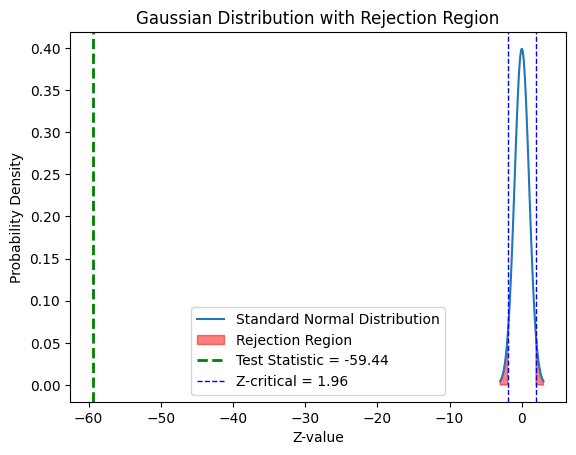

In [12]:
# Parameters for the standard normal distribution
mu = 0  # Mean
sigma = 1  # Standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)


# Plotting the standard normal distribution
plt.plot(x, y, label='Standard Normal Distribution')
# Shade the rejection region for a two-tailed test
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color='red', alpha=0.5, label='Rejection Region')
# Adding Test Statistic
plt.axvline(Test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {Test_stat:.2f}')
# Adding Z-critical values
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=1)

# Adding labels and title
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region')
plt.legend()
# Show plot
plt.show()

## Confidence Interval of the test

In [13]:
# Calculate the Confidence Interval (CI) for a 2-sample Z-test
## Calculate the lower and upper bounds of the confidence interval
CI_95 = [
    float(round((p_exp_hat - p_con_hat) - SE*Z_crit, 3)),  # Lower bound of the CI, rounded to 3 decimal places
    float(round((p_exp_hat - p_con_hat) + SE*Z_crit, 3))   # Upper bound of the CI, rounded to 3 decimal places
]

# Print the calculated confidence interval
print("Confidence Interval of the 2 sample Z-test is: ", CI_95)

# Here, the confidence interval provides a range of values within which the true difference between the experimental and control group proportions is likely to lie with a certain level of confidence (e.g., 95%).


Confidence Interval of the 2 sample Z-test is:  [0.399, 0.426]


## Testing for Practical Significance in A/B Testing

The Minimum Detectable Effect (MDE) helps ensure that even though we have statistical significance, the results are meaningful enough to justify business action.

In [14]:

def is_Practically_significant(delta, CI_95):
    """
    We assess here if the difference between Control and Experimental group is practically significant using the Minimum Detectable Effect (MDE) parameter from the Power Analysis.

    Arguments:
    - delta (float): The Minimum Detectable Effect (MDE) considered for practical significance.
    - CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% Confidence Interval.

    Returns:
    - Prints whether the experiment has practical significance based on the MDE and CI.
    """

    # Extract lower bound of 95% Confidence Interval
    lower_bound_CI = CI_95[0]


    # Check if the lower bound of the CI is greater than or equal to delta
    if lower_bound_CI >= delta:
        print(f"We have practical significance! \nWith MDE of {delta}, The difference between Control and Experimental group is practically significant.")
        return True
    else:
        print("We don't have practical significance! \nThe difference between Control and Experimental group is not practically significant.")
        return False



# Call the function
significance = is_Practically_significant(delta, CI_95)
print("Lower bound of 95% confidence interval is: ", CI_95[0])

We have practical significance! 
With MDE of 0.1, The difference between Control and Experimental group is practically significant.
Lower bound of 95% confidence interval is:  0.399


## Conclusion and Business Implications
The A/B test results indicate a statistically significant improvement in the experimental group's click-through rate compared to the control group, with a p-value below 0.05, allowing us to reject the null hypothesis.

Additionally, the test meets the 10% MDE threshold, confirming that the observed difference is both statistically and practically significant.

These findings suggest that adopting the new call-to-action button text could lead to increased conversions, enhanced user engagement, and potential revenue growth for the business.
